In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from pyclustering.cluster.kmedians import kmedians
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster import cluster_visualizer_multidim
from sklearn.decomposition import PCA
import pickle
from tqdm.notebook import tqdm

In [46]:
population_data_raw = pd.read_csv('../Data/population.csv')
more_than_50_raw = pd.read_csv('../Data/more_than_50k.csv')

In [47]:
def preprocessing(df):

    #replace ? with Nan
    df = df.replace({' ?' :  np.nan})

    #drop columns with more than 40$ NaN values
    cols = df.columns
    missing_percentages = (df.isna().sum() / len(df)) * 100
    cols_to_drop = []
    for col in cols:
        if(missing_percentages[col] > 40.0):
            cols_to_drop.append(col)
    print(f'Dropping = {cols_to_drop}')
    df = df.drop(cols_to_drop, axis=1)
    return df

In [48]:
data = preprocessing(population_data_raw)
print(f'Population data shape: {data.shape}')
data_more_than_50 = preprocessing(more_than_50_raw)
print(f'More than 50k data shape: {data_more_than_50.shape}')

Dropping = ['MIGMTR1', 'MIGMTR3', 'MIGMTR4', 'MIGSUN']
Population data shape: (199523, 36)
Dropping = ['MIGMTR1', 'MIGMTR3', 'MIGMTR4', 'MIGSUN']
More than 50k data shape: (3580, 36)


In [49]:
def plot_histogram(df, numeric_columns, anum):
    # features = df.columns
    # for feat in features:
    #     plt.figure(figsize=(25,5))
    #     if(feat in numeric_columns):
    #         df[feat].hist(bins=10,edgecolor='black', linewidth=1.5)

    #     else:
    #         unique_cat_values = len(df[feat].unique())
    #         print(f'No. of unique Categories : {unique_cat_values}')
    #         df[feat].hist(bins = unique_cat_values, edgecolor='black', linewidth=1.5)
    #     plt.xlabel(feat)
    #     plt.ylabel('Count')
    #     plt.title(f'Histogram : {feat}')
    #     plt.savefig(f'../Plots/Feature_Analysis/{feat}_hist', facecolor='w', bbox_inches='tight')
    #     plt.show()
    features = df.columns
    for feat in features:
        plt.figure(figsize=(25, 5))
        if(feat in numeric_columns):
            print('Numeric Column')
            df[feat].astype(str).hist(bins = 6, edgecolor='black', linewidth=1.5)
            
        else:
            unique_cat_values = len(df[feat].unique())
            print(f'Categorical Column || No. of unique Categories : {unique_cat_values}')
            df[feat].astype(str).hist(bins = unique_cat_values, edgecolor='black', linewidth=1.5)
        plt.xlabel(feat)
        plt.ylabel('Count')
        plt.title(f'Histogram : {feat}')
        plt.savefig(f'../Plots/Feature_Analysis_{anum}/{feat}_hist', facecolor='w', bbox_inches='tight')
        plt.show()

In [50]:
def feature_analysis(df, anum):
    data_columns = df.columns
    numeric_columns = ['AAGE', 'AHRSPAY', 'CAPGAIN', 'CAPLOSS', 'DIVVAL', 'WKSWORK']
    df_copy = df.copy(deep=True)
    for col in numeric_columns:
        df_copy[col] = pd.cut(x=df_copy[col], bins=6)
    # plot_histogram(df_copy, numeric_columns, anum)
    total_count = df_copy.shape[0]
    cols_to_drop = []
    for col in df_copy.columns:
        max_freq = df_copy[col].value_counts().max()
        max_perc = (max_freq / total_count) * 100
        if(max_perc > 80.0):
            cols_to_drop.append(col)
    print(f'{anum} : Dropping {len(cols_to_drop)} cols \n {cols_to_drop}')
    df = df.drop(cols_to_drop, axis=1)
    return df, cols_to_drop

    # print(df)
    # print(categorical_cols)


In [51]:
data, cols_to_drop_1 = feature_analysis(data, 1)
data_more_than_50, cols_to_drop_2 = feature_analysis(data_more_than_50, 2)

1 : Dropping 16 cols 
 ['AHRSPAY', 'AHSCOL', 'ARACE', 'AREORGN', 'AUNMEM', 'AUNTYPE', 'CAPGAIN', 'CAPLOSS', 'DIVVAL', 'GRINREG', 'GRINST', 'PEMNTVTY', 'PENATVTY', 'PRCITSHP', 'SEOTR', 'VETQVA']
2 : Dropping 20 cols 
 ['AHRSPAY', 'AHSCOL', 'ARACE', 'AREORGN', 'AUNMEM', 'AUNTYPE', 'CAPGAIN', 'CAPLOSS', 'DIVVAL', 'GRINREG', 'GRINST', 'PARENT', 'PEFNTVTY', 'PEMNTVTY', 'PENATVTY', 'PRCITSHP', 'SEOTR', 'VETQVA', 'VETYN', 'WKSWORK']


In [52]:
# column_modes_1 = data.mode()
# column_modes_1

In [53]:
def column_modifications(df):
    column_modes = df.mode()
    data_cols = df.columns
    numeric_columns = ['AAGE', 'AHRSPAY', 'CAPGAIN', 'CAPLOSS', 'DIVVAL', 'WKSWORK']
    for col in data_cols:
        missing_vals = df[col].isna().sum()
        if(missing_vals > 0):
            df[col] = df[col].fillna(column_modes[col][0])
    for col in df.columns:
        if(col in numeric_columns):
            df[col] = pd.cut(x=df[col], bins=6)
    one_hot_encoded = pd.get_dummies(df, columns=list(df.columns))
    df = one_hot_encoded
    return df

In [54]:
data = column_modifications(data)
print(data.shape)
data_more_than_50 = column_modifications(data_more_than_50)
print(data_more_than_50.shape)

(199523, 307)
(3580, 217)


PCA 

In [55]:
def performPCA(df, anum):
    pca = PCA()
    pca.fit(np.array(df))
    exp_var_rat = pca.explained_variance_ratio_
    cum_exp_var_perc = np.cumsum(exp_var_rat)
    plt.plot(cum_exp_var_perc)
    plt.xlabel('Cumulative explained variance')
    plt.ylabel('Number of components')
    plt.title(f'PCA Analysis - {anum}')
    plt.savefig(f'../Plots/Dimensionality_Reduction/pca_plot_{anum}.png', facecolor='white', bbox_inches='tight')
    plt.show()

    return pca, cum_exp_var_perc   

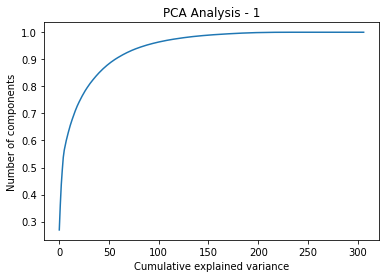

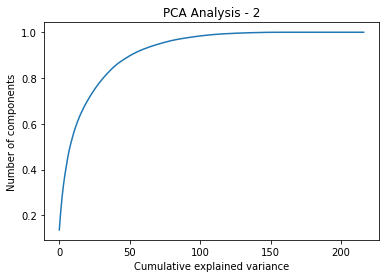

In [56]:
pca_1, cum_var_1 = performPCA(data, 1)
pca_2, cum_var_2 = performPCA(data_more_than_50, 2)

In [57]:
pca_final_1 = PCA(n_components=40)
dim_reduced_data_1 = pca_final_1.fit_transform(np.array(data))

pca_final_2 = PCA(n_components=40)
dim_reduced_data_2 = pca_final_2.fit_transform(np.array(data_more_than_50))

print(f' 1 - {dim_reduced_data_1.shape}')
print(f' 2 - {dim_reduced_data_2.shape}')

 1 - (199523, 40)
 2 - (3580, 40)


CLUSTERING

In [58]:
num_samples_1 = data.shape[0]
num_samples_2 = data_more_than_50.shape[0]
print(num_samples_1, num_samples_2)

199523 3580


In [91]:
def compute_avg_within_cluster_dist(dim_red_data, clust, centroids, k):
    total_sum = 0
    for i in range(k):
        clust_dist = 0
        print(f'i = {i} | len = {len(clust)}')
        for idx in clust[i]:
            point = np.array(dim_red_data[idx])
            dist_val = np.sqrt(np.sum(np.square(point - centroids[i])))
            clust_dist += dist_val
        total_sum += clust_dist / len(clust[i])
    return total_sum / k

In [110]:
def plot_clust_dist(avg_clust_distance, anum):
    plt.plot([x for x in range(10, 25)], list(avg_clust_distance.values()), marker='o')
    plt.xlabel('No. of clusters')
    plt.ylabel('Average cluster distance')
    plt.title(f'avg cluster distance vs number of clusters-{anum}')
    plt.savefig(f'../Plots/cluster_distance_{anum}', facecolor='white', bbox_inches='tight')
    plt.show()

In [61]:
avg_cluster_distance_byK_1 = {}
avg_cluster_distance_byN_1 = {}
avg_within_cluster_distance_1 = {}
for k_value in tqdm(range(10, 25)):

    print(f'-------- K VALUE = {k_value} --------')
    random_points_1 = np.array(pd.DataFrame(dim_reduced_data_1).sample(n=k_value)).tolist()

    # print('PERFORMING CLUSTERING')
    medians_init_1 = random_points_1
    kmedians_clusterer_1 = kmedians(dim_reduced_data_1, medians_init_1)
    kmedians_clusterer_1.process()

    file = open(f'../models/Part_1/kmedians_{k_value}.pickle', 'wb')
    pickle.dump(kmedians_clusterer_1, file)
    file.close()

    clusters_1 = kmedians_clusterer_1.get_clusters()
    medians_1 = kmedians_clusterer_1.get_medians()
    print(f'len cluster = {len(clusters_1)} || len medians = {len(medians_1)}')
    np.save(f'../model_info/Part_1/clusters_{k_value}.npy', np.array(clusters_1))
    np.save(f'../model_info/Part_1/medians_{k_value}.npy', np.array(medians_1))

    avg_dist_byK_1 = kmedians_clusterer_1.get_total_wce() / k_value
    avg_dist_byN_1 = kmedians_clusterer_1.get_total_wce() / num_samples_1
    avg_within_clust_dist_1 = compute_avg_within_cluster_dist(dim_reduced_data_1, clusters_1, medians_1, k_value)
    
    avg_cluster_distance_byK_1[k_value] = avg_dist_byK_1
    avg_cluster_distance_byN_1[k_value] = avg_dist_byN_1
    avg_within_cluster_distance_1[k_value] = avg_within_clust_dist_1
    print(f'average within cluster distance (byK) = {avg_dist_byK_1}')
    print(f'average within cluster distance (byN) = {avg_dist_byN_1}')
    print(f'average within cluster distance = {avg_within_clust_dist_1}')
    # print('INSTANCE PROCESSED')



  0%|          | 0/15 [00:00<?, ?it/s]

-------- K VALUE = 10 --------
len cluster = 10 || len medians = 10
i = 0 | len = 10


C:\Users\SAMYAK~1\AppData\Local\Temp/ipykernel_5852/1798722348.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(f'../model_info/Part_1/clusters_{k_value}.npy', np.array(clusters_1))


i = 1 | len = 10
i = 2 | len = 10
i = 3 | len = 10
i = 4 | len = 10
i = 5 | len = 10
i = 6 | len = 10
i = 7 | len = 10
i = 8 | len = 10
i = 9 | len = 10
average within cluster distance (byK) = 179206.1776156821
average within cluster distance (byN) = 8.981730307567654
average within cluster distance = 2.7734242952167505
-------- K VALUE = 11 --------
len cluster = 11 || len medians = 11
i = 0 | len = 11
i = 1 | len = 11
i = 2 | len = 11
i = 3 | len = 11
i = 4 | len = 11
i = 5 | len = 11
i = 6 | len = 11
i = 7 | len = 11
i = 8 | len = 11
i = 9 | len = 11
i = 10 | len = 11
average within cluster distance (byK) = 159180.46994018226
average within cluster distance (byN) = 8.775856263899424
average within cluster distance = 2.6638183874634147
-------- K VALUE = 12 --------
len cluster = 12 || len medians = 12
i = 0 | len = 12
i = 1 | len = 12
i = 2 | len = 12
i = 3 | len = 12
i = 4 | len = 12
i = 5 | len = 12
i = 6 | len = 12
i = 7 | len = 12
i = 8 | len = 12
i = 9 | len = 12
i = 10 | len =

IndexError: list index out of range

In [ ]:
plot_clust_dist(avg_within_cluster_distance_1, 1)

In [ ]:
plt.plot([x for x in range(10, 25)], list(avg_cluster_distance_byK_1.values()), marker='o')
plt.xlabel('No. of clusters')
plt.ylabel('Average cluster distance')
plt.title('avg cluster distance vs number of clusters(byK) (1)')
# plt.savefig(f'../Plots/cluster_distance_{anum}', facecolor='white', bbox_inches='tight')
plt.show()

In [ ]:
plt.plot([x for x in range(10, 25)], list(avg_cluster_distance_byN_1.values()), marker='o')
plt.xlabel('No. of clusters')
plt.ylabel('Average cluster distance')
plt.title('avg cluster distance vs number of clusters(byN) (1)')
# plt.savefig(f'../Plots/cluster_distance_{anum}', facecolor='white', bbox_inches='tight')
plt.show()

More than 50k

In [108]:
avg_cluster_distance_byK_2 = {}
avg_cluster_distance_byN_2 = {}
avg_within_cluster_distance_2 = {}

for k_value in tqdm(range(10, 25)):
    
    print(f'-------- K VALUE = {k_value} --------')
    random_points_2 = np.array(pd.DataFrame(dim_reduced_data_2).sample(n=k_value)).tolist()
    # print(random_points_2.shape)
    # random_points_2 = np.zeros((k_value, 40))
    
    # print('PERFORMING CLUSTERING')
    medians_init_2 = random_points_2
    print(np.array(medians_init_2).shape)
    kmedians_clusterer_2 = kmedians(dim_reduced_data_2, medians_init_2)
    kmedians_clusterer_2.process()

    file = open(f'../models/Part_2/kmedians_{k_value}.pickle', 'wb')
    pickle.dump(kmedians_clusterer_2, file)
    file.close()

    clusters_2 = kmedians_clusterer_2.get_clusters()
    medians_2 = kmedians_clusterer_2.get_medians()
    np.save(f'../model_info/Part_2/clusters_{k_value}.npy', np.array(clusters_2))
    np.save(f'../model_info/Part_2/medians_{k_value}.npy', np.array(medians_2))

    avg_dist_byK_2 = kmedians_clusterer_2.get_total_wce() / k_value
    avg_dist_byN_2 = kmedians_clusterer_2.get_total_wce() / num_samples_2
    avg_within_clust_dist_2 = compute_avg_within_cluster_dist(dim_reduced_data_2, clusters_2, medians_2, k_value)

    avg_cluster_distance_byK_2[k_value] = avg_dist_byK_2
    avg_cluster_distance_byN_2[k_value] = avg_dist_byN_2
    avg_within_cluster_distance_2[k_value] = avg_within_clust_dist_2
    print(f'average within cluster distance (byK) = {avg_dist_byK_2}')
    print(f'average within cluster distance (byN) = {avg_dist_byN_2}')
    print(f'average within cluster distance = {avg_within_clust_dist_2}')
    # print('INSTANCE PROCESSED')



  0%|          | 0/15 [00:00<?, ?it/s]

-------- K VALUE = 10 --------
(10, 40)


C:\Users\SAMYAK~1\AppData\Local\Temp/ipykernel_5852/71215536.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(f'../model_info/Part_2/clusters_{k_value}.npy', np.array(clusters_2))


i = 0 | len = 10
i = 1 | len = 10
i = 2 | len = 10
i = 3 | len = 10
i = 4 | len = 10
i = 5 | len = 10
i = 6 | len = 10
i = 7 | len = 10
i = 8 | len = 10
i = 9 | len = 10
average within cluster distance (byK) = 3745.26343655066
average within cluster distance (byN) = 10.461629711035364
average within cluster distance = 3.179187579227769
-------- K VALUE = 11 --------
(11, 40)
i = 0 | len = 11
i = 1 | len = 11
i = 2 | len = 11
i = 3 | len = 11
i = 4 | len = 11
i = 5 | len = 11
i = 6 | len = 11
i = 7 | len = 11
i = 8 | len = 11
i = 9 | len = 11
i = 10 | len = 11
average within cluster distance (byK) = 3311.7216502132
average within cluster distance (byN) = 10.175681048141119
average within cluster distance = 3.1259311022551297
-------- K VALUE = 12 --------
(12, 40)
i = 0 | len = 12
i = 1 | len = 12
i = 2 | len = 12
i = 3 | len = 12
i = 4 | len = 12
i = 5 | len = 12
i = 6 | len = 12
i = 7 | len = 12
i = 8 | len = 12
i = 9 | len = 12
i = 10 | len = 12
i = 11 | len = 12
average within clust

ValueError: x and y must have same first dimension, but have shapes (24,) and (15,)

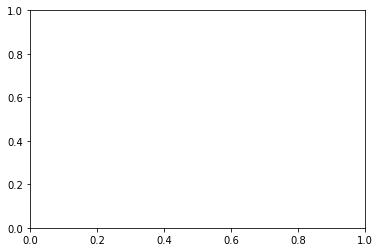

In [109]:
plot_clust_dist(avg_within_cluster_distance_2, 2)

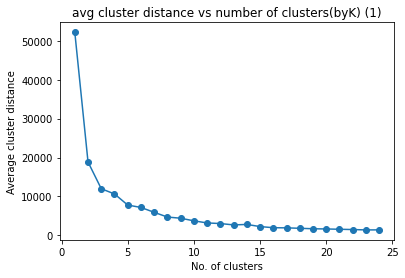

In [ ]:
plt.plot([x for x in range(10, 25)], list(avg_cluster_distance_byK_2.values()), marker='o')
plt.xlabel('No. of clusters')
plt.ylabel('Average cluster distance')
plt.title('avg cluster distance vs number of clusters(byK) (1)')
# plt.savefig(f'../Plots/cluster_distance_{anum}', facecolor='white', bbox_inches='tight')
plt.show()

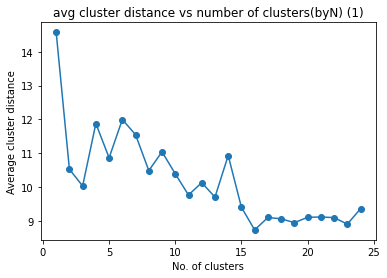

In [ ]:
plt.plot([x for x in range(10, 25)], list(avg_cluster_distance_byN_2.values()), marker='o')
plt.xlabel('No. of clusters')
plt.ylabel('Average cluster distance')
plt.title('avg cluster distance vs number of clusters(byN) (1)')
# plt.savefig(f'../Plots/cluster_distance_{anum}', facecolor='white', bbox_inches='tight')
plt.show()